In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom as di
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from PIL import Image
from random import choice
from tensorflow.keras.callbacks import TensorBoard
import datetime

2023-02-18 23:37:38.040402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_dir = "../dataset/train_images/"
test_dir = "../dataset/test_images/"

In [3]:
# Loading the CSV file and cleaning the data
train_csv = pd.read_csv("../dataset/train.csv")
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [4]:
train_csv.isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [5]:
#Exploring data
print(f"<-- Difficult negative case --> \n {train_csv['difficult_negative_case'].value_counts()}\n")

print(f"<-- Cancer --> \n {train_csv['cancer'].value_counts()}\n")

# The data is very skewed.

<-- Difficult negative case --> 
 False    47001
True      7705
Name: difficult_negative_case, dtype: int64

<-- Cancer --> 
 0    53548
1     1158
Name: cancer, dtype: int64



In [6]:
#Function to get numpy array of the given image_id
def imageid_to_numpy(patient_id, image_id):
    path_to_images = f"{train_dir}{patient_id}/{image_id}.dcm"
    dcm_image = di.dcmread(path_to_images)
    np_array = dcm_image.pixel_array
    return np_array

#Function to copy dcm image as png
def copy_dcm_as_png(path_to_dcm, png_save_path):
    im = Image.fromarray(imageid_to_numpy(path_to_dcm))
    im.save(png_save_path)


### Work in progress
# takes df with info of a single patient and concats the corresponding images into one
def image_concat(patient_df):
    image_array = []
    for image_id in patient_df[patient_df['laterality'] == 'L']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))
    
    row1 = np.concatenate(6(image_array[0], image_array[1]), axis = 1) # concat L images

    for image_id in patient_df[patient_df['laterality'] == 'R']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))

    row2 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat R images

    final_image = np.concatenate((row1, row2), axis=0) # concat L and R images

    # im = Image.fromarray(final_image)
    # im = im.convert('RGB')
    # im.save('./concat_images/{}.png'.format(patient_id), compress_level = 1)

    cv2.imwrite('./concat_images/{}.png'.format(patient_df['patient_id'][0]), final_image)

    #####
    # processing is very slow for some reason
    #####

<>:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_23887/3954163558.py:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  row1 = np.concatenate(6(image_array[0], image_array[1]), axis = 1) # concat L images


In [7]:
# Creating colums for n_images -> Number of images for each patient.
#                     resolution -> Dimensions of the corresponding image.
train_csv['n_images'] = [0 for _ in range(train_csv.shape[0])]
train_csv['resolution'] = [None for _ in range(train_csv.shape[0])]
train_csv['readable'] = [None for _ in range(train_csv.shape[0])]
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None


In [8]:
# Getting the resolution for each image and the numberr of images each patient has.

try:
    processed_train_csv = pd.read_csv("processed_train.csv")
except:
    for patient in tqdm(train_csv['patient_id'].unique()):
        for image in os.listdir(train_dir + str(patient)):
            try:
                current_image = imageid_to_numpy(patient, image[:-4])
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = True
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), 'resolution'] = f"{current_image.shape[0]} {current_image.shape[1]}"
            except NotImplementedError:
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = False
    train_csv.to_csv("./processed_train.csv")
    processed_train_csv = train_csv
    for patient in processed_train_csv["patient_id"].unique():
        n_images = processed_train_csv[processed_train_csv["patient_id"] == patient].shape[0]
        processed_train_csv.loc[processed_train_csv["patient_id"] == patient, "n_images"] = n_images
        


(array([5.4702e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

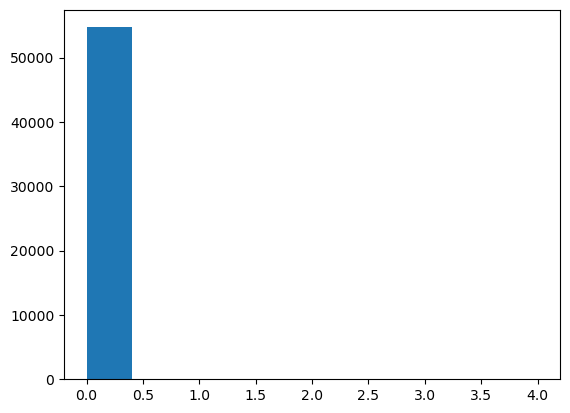

In [9]:
plt.hist(processed_train_csv["n_images"])

(array([8.2670e+03, 8.2210e+03, 2.7030e+03, 1.2760e+03, 9.0420e+03,
        2.4109e+04, 3.3800e+02, 7.3200e+02, 1.3000e+01, 5.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

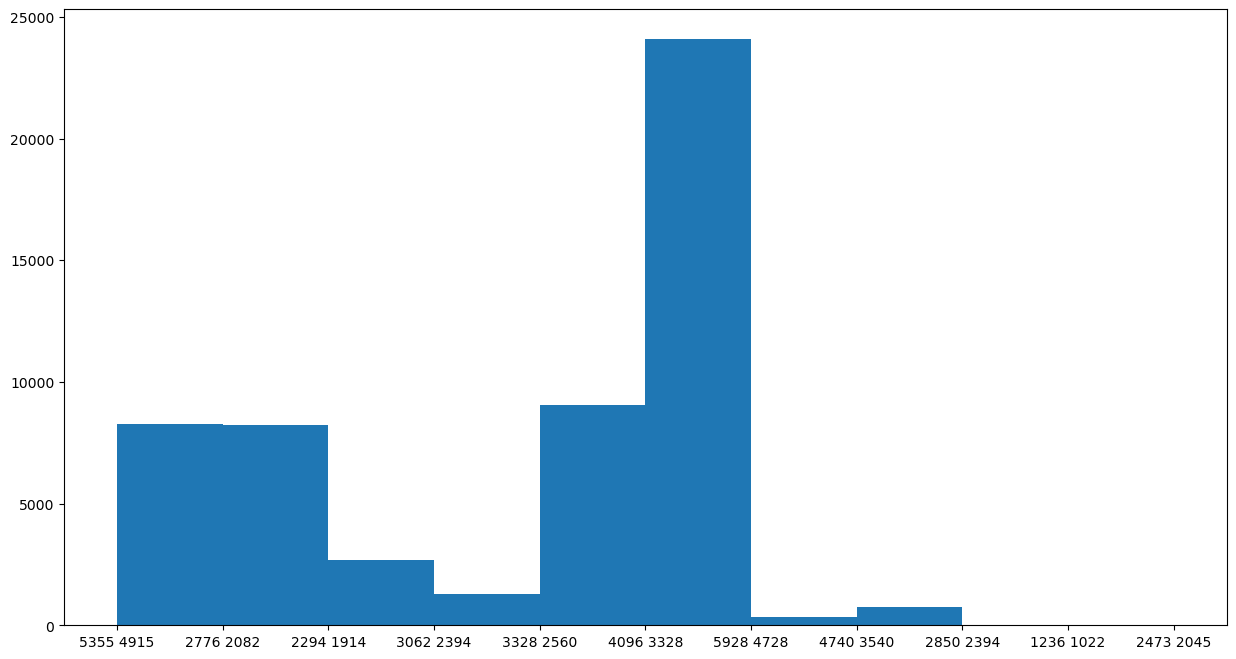

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
axes.hist(processed_train_csv["resolution"])



(array([600.,   0., 154.,   0., 161.,   0., 216.,   0.,  11.,  16.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

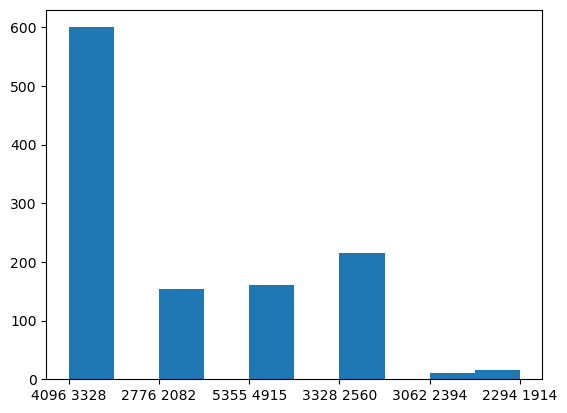

In [11]:
plt.hist(processed_train_csv.loc[processed_train_csv["cancer"] == 1]["resolution"])

In [12]:
processed_train_csv[processed_train_csv["resolution"] == "4096 3328"]

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
47,47,1,10097,664674273,L,MLO,44.0,0,0,0,1.0,0,C,49,False,0,4096 3328,True
48,48,1,10097,929754876,L,CC,44.0,0,0,0,1.0,0,C,49,False,0,4096 3328,True
49,49,1,10097,1957744616,L,CC,44.0,0,0,0,1.0,0,C,49,False,0,4096 3328,True
50,50,1,10097,166011602,R,MLO,44.0,0,0,0,1.0,0,C,49,False,0,4096 3328,True
51,51,1,10097,268368896,R,CC,44.0,0,0,0,1.0,0,C,49,False,0,4096 3328,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54689,54689,2,9967,1260162631,R,CC,62.0,0,0,0,NaN,0,NaN,48,False,0,4096 3328,True
54690,54690,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False,0,4096 3328,True
54691,54691,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False,0,4096 3328,True
54692,54692,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False,0,4096 3328,True


In [13]:
# rand_patient = choice(processed_train_csv.loc[processed_train_csv['resolution'] == "4096 3328"]["patient_id"].unique())
rand_patient = choice(processed_train_csv.loc[processed_train_csv['patient_id'] == 28844]['image_id'].unique())

rand_patient

1422320362

In [14]:
# rand_patient = choice(processed_train_csv.loc[processed_train_csv['resolution'] == "4096 3328"]["patient_id"].unique())
# rand_patient = 46905
# rand_image = choice(processed_train_csv.loc[processed_train_csv['patient_id'] == rand_patient]['image_id'].unique())
# print(processed_train_csv.loc[processed_train_csv['image_id'] == rand_image]['cancer'])

# image = imageid_to_numpy(rand_patient, rand_image) * 10

# image1 = cv2.resize(image, (500, 500))

# cv2.imshow("output", image1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

(array([   59.,   341.,  4562.,  9344., 11092., 11321., 11511.,  4380.,
         1530.,   529.]),
 array([26. , 32.3, 38.6, 44.9, 51.2, 57.5, 63.8, 70.1, 76.4, 82.7, 89. ]),
 <BarContainer object of 10 artists>)

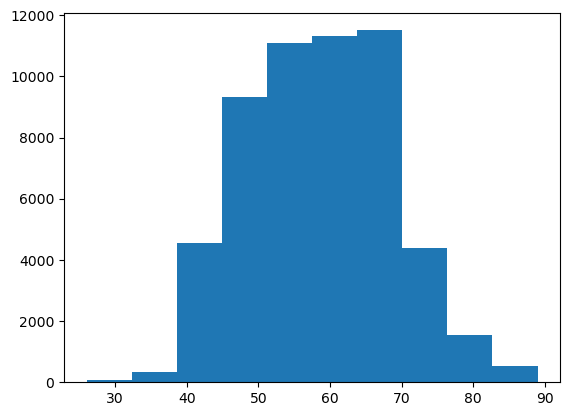

In [15]:
plt.hist(processed_train_csv["age"])

In [16]:
cancer_train_df = processed_train_csv[processed_train_csv["cancer"] == 1]


train_df= cancer_train_df.append( processed_train_csv[processed_train_csv["cancer"] == 0].sample(n = cancer_train_df.shape[0], replace=False))


/tmp/ipykernel_23887/2392677194.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df= cancer_train_df.append( processed_train_csv[processed_train_csv["cancer"] == 0].sample(n = cancer_train_df.shape[0], replace=False))


In [17]:
train_df = train_df.sample(frac = 1).reset_index()
train_df.head()

,index,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
0,15865,15865,1,26862,192415761,R,CC,68.0,1,1,1,0.0,0,B,49,False,0,4096 3328,True
1,1704,1704,1,11825,1159492822,L,MLO,43.0,0,0,0,1.0,0,B,49,False,0,4096 3328,True
2,17796,17796,1,28785,216760793,L,MLO,65.0,1,1,1,0.0,0,B,49,False,0,4096 3328,True
3,1357,1357,1,11405,327342669,R,CC,59.0,0,0,0,1.0,1,C,49,False,0,3328 2560,True
4,36799,36799,2,49485,1586224451,R,CC,54.0,1,1,0,NaN,0,NaN,29,False,0,5355 4915,True


In [18]:
#drop columns
train_df_ids = train_df["image_id"]
train_df_ids.shape

(2316,)

In [19]:
train_labels = train_df["cancer"]
train_labels.shape

(2316,)

In [20]:
dimension = 100

In [30]:
import pickle
try:
    with open("./xtrain3.pkl", "rb") as f:
        train_x = pickle.load(f)
except:
    ## Creating image numpy array of size N examples X dimensions ** 2 (2316, 10000)

    train_x = np.zeros((train_labels.shape[0],  dimension, dimension))

    for row in tqdm(train_df.iterrows()):
        image_array = imageid_to_numpy(row[1]["patient_id"], row[1]["image_id"])
        image_array = cv2.resize(image_array, (dimension, dimension)) 
        # print(np.max(image_array), end=" <> ")
        normalized_array = image_array / np.max(image_array)
        # train_x = np.append(train_x, image_array.flatten(), 1)
        # train_x = np.concatenate((train_x, normalized_array.flatten()), 1)
        train_x[row[0]] = normalized_array
    

    with open("./xtrain3.pkl", "wb") as f:
        pickle.dump(train_x, f)

In [22]:
train_x.shape[1:]

(100, 100)

In [23]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
train_x = tf.expand_dims(train_x, axis=-1)

2023-02-18 23:37:39.975011: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-18 23:37:39.975553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-18 23:37:39.984966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 23:37:39.985052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 80 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 849.46GiB/s
2023-02-18 23:37:39.985069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-18 23:37:39.985883: I tensorflow/stream_executor/platfor

In [25]:
train_x.shape

TensorShape([2316, 100, 100, 1])

In [26]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=train_x.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:


model.compile(optimizer="Adam", 
                loss = "binary_crossentropy",
                metrics=["accuracy"]
              )


In [28]:

tensorboard = TensorBoard(log_dir = os.path.join("logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),).format("Breast Cancer") )

2023-02-18 23:37:41.081654: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-18 23:37:41.081671: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-18 23:37:41.081706: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-02-18 23:37:41.082229: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-02-18 23:37:41.182635: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-02-18 23:37:41.182913: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [29]:
hist = model.fit(train_x, train_labels, epochs=10, callbacks= [tensorboard], verbose=2)
model.save('classifier.h5')

2023-02-18 23:37:41.232096: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 185280000 exceeds 10% of free system memory.
2023-02-18 23:37:41.293133: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-18 23:37:41.293358: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496000000 Hz


Epoch 1/10


2023-02-18 23:37:41.498139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-18 23:38:18.546043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-18 23:48:27.885390: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-02-18 23:48:27.962622: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-18 23:48:32.797264: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-18 23:48:32.797285: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-18 23:48:32.797780: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] func

73/73 - 658s - loss: nan - accuracy: 0.5000
Epoch 2/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 3/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 4/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 5/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 6/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 7/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 8/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 9/10
73/73 - 1s - loss: nan - accuracy: 0.5000
Epoch 10/10
73/73 - 1s - loss: nan - accuracy: 0.5000
